In [1]:
from springtime import data_utils

In [15]:
# Field observations (truth)
ppo_options = {
    "genus": "Syringa",
    "source": "USA-NPN", # because daymet covers USA
    "year": "[2019 TO 2020]",
    "latitude": "[39.5 TO 40.1]",
    "longitude": "[-86.5 TO -86]",
    "termID": "obo:PPO_0002313", # true leaves present
}
obs_df = data_utils.prepare_observations("ppo", ppo_options)
unique_idx = ['latitude', 'longitude', 'year']
event = obs_df.groupby(unique_idx).dayOfYear.mean().reset_index()

Sending request: https://biscicol.org/api/v3/download/_search?limit=1535&q=genus:Syringa+AND+source:USA-NPN+AND+year:[2019 TO 2020]+AND+latitude:[39.5 TO 40.1]+AND+longitude:[-86.5 TO -86]+AND+termID:"obo:PPO_0002313"

Retrieved 76 of 76 total possible results.
Please note the additional download and license information in df.attrs
PPO data are retrieved.


In [3]:
# "(New) proxy data"
daymet_options = {
    "longitudes": [-86.5, -86], # very high resolution data, so small area
    "latitudes": [39.5, 40.1],
    "var_names": ['tmax', 'tmin', 'prcp'], # features
    "years": [2019, 2020],
    "statistics": "annual seasonal average", # convert daily to seasonal
}

eo_ds = data_utils.prepare_eo("Daymet", daymet_options)

Daymet data are retrieved.
Calculating statistics (loading data into memory) ...


In [17]:
# "Weather/satellite data (proxy)"
eo_obs_df = data_utils.merge_eo_obs(eo_ds, obs_df)
unique_idx = ['latitude', 'longitude', 'year', 'season']
proxy = eo_obs_df.groupby(unique_idx).tmax.mean().reset_index()
proxy = proxy.loc[(proxy['season'] == 'MAM')&(proxy['year'] == 2019)]

In [18]:
# "Expected truth"
# generated using usecase1_example.py
import xarray as xr
predicted = xr.open_dataset("./DayOfYear_2019_predcited.nc")

In [19]:
# plots
import matplotlib.pyplot as plt
from cartopy import crs

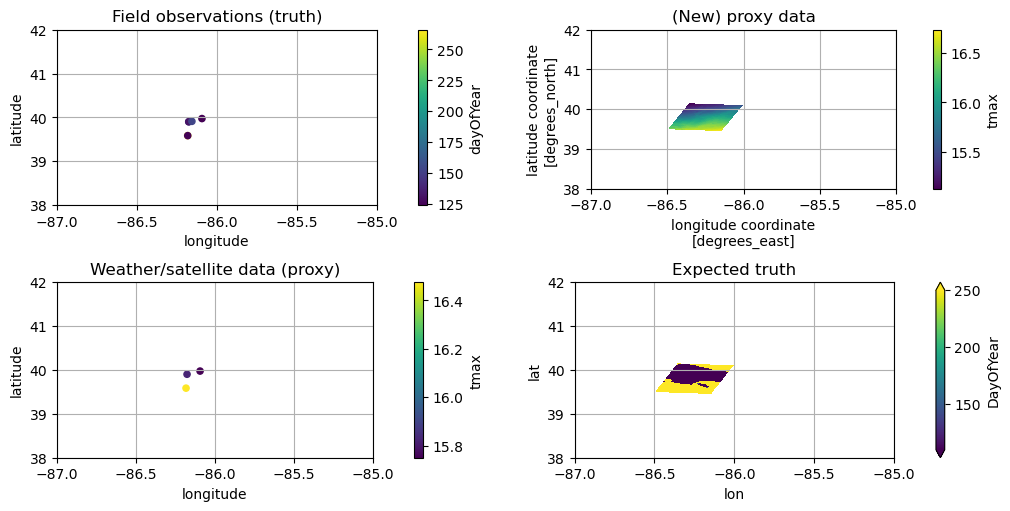

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
subfigs = fig.subfigures(2, 2, wspace=0.07)

ax1 = subfigs[0][0].add_subplot()
ax1.set_xlim(-87, -85)
ax1.set_ylim(38, 42)
event.plot(kind='scatter', x='longitude', y='latitude', c='dayOfYear', cmap="viridis", ax=ax1)
ax1.grid()
ax1.set_title("Field observations (truth)")

ax2 = subfigs[0][1].add_subplot()
cf = eo_ds.tmax.sel(year=2019, season='MAM').plot( 
    x='lon', y='lat',
    add_colorbar=True
)
ax2.set_xlim(-87, -85)
ax2.set_ylim(38, 42)
ax2.grid()
ax2.set_title("(New) proxy data")

ax3 = subfigs[1][0].add_subplot()
proxy.plot(kind='scatter', x='longitude', y='latitude', c='tmax', cmap="viridis", ax=ax3)
ax3.set_xlim(-87, -85)
ax3.set_ylim(38, 42)
ax3.grid()
ax3.set_title("Weather/satellite data (proxy)")

ax4 = subfigs[1][1].add_subplot()
cf = predicted.DayOfYear.plot( 
    x='lon', y='lat',
    cmap="viridis",
    vmax=250,
    vmin=110, # due to outliesr
    add_colorbar=True
)
ax4.set_xlim(-87, -85)
ax4.set_ylim(38, 42)
ax4.grid()
ax4.set_title("Expected truth")

plt.show()